Cell 1: Imports and Setup

In [2]:
# Imports and reproducibility setup
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Cell 2: Data Loading and Exploration

In [3]:
def load_and_explore_data():
    """
    Load the MNIST dataset and print out some basic statistics.
    """
    # Define image transformation (convert images to tensor)
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the training dataset
    train_ds = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Print dataset statistics
    print("Dataset shape:", train_ds.data.shape)
    print("Targets shape:", train_ds.targets.shape)
    print("Classes:", train_ds.classes)

    # Analyze the first image
    first_image = train_ds.data[0]
    print("\nFirst image values:\n", first_image)
    print("First image label:", train_ds.targets[0].item())
    print("Max pixel value:", first_image.max().item())
    print("Min pixel value:", first_image.min().item())
    print("Mean pixel value:", first_image.float().mean().item())
    print("Pixel std deviation:", first_image.float().std().item())

    return train_ds

# Load the dataset and explore it
train_ds = load_and_explore_data()


Dataset shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

First image values:
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,  

Cell 3: Create DataLoader

In [4]:
# Define batch size and create a DataLoader for the dataset
batch_size = 64
loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


Cell 4: Model Definitions (Discriminator and Generator)

In [5]:
# Define the Discriminator network
class Discriminator(nn.Module):
    """Discriminator network to differentiate real and fake images."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.fc4 = nn.Linear(32, out_features)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        # Forward pass through the network
        x = self.leaky_relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu3(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

# Define the Generator network
class Generator(nn.Module):
    """Generator network to create fake images."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(32, 64)
        self.relu2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(64, 128)
        self.relu3 = nn.LeakyReLU(0.2)
        self.fc4 = nn.Linear(128, out_features)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Forward pass through the network
        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        return self.tanh(self.fc4(x))


Cell 5: Utility Functions

In [6]:
def real_loss(predicted, loss_fn, device):
    """Calculate loss for real samples (target = 1)."""
    batch_size = predicted.size(0)
    targets = torch.ones(batch_size, device=device)
    return loss_fn(predicted.squeeze(), targets)

def fake_loss(predicted, loss_fn, device):
    """Calculate loss for fake samples (target = 0)."""
    batch_size = predicted.size(0)
    targets = torch.zeros(batch_size, device=device)
    return loss_fn(predicted.squeeze(), targets)

def display_images(images, n_cols=4, figsize=(12, 6)):
    """Display images in a grid."""
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)

    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        img = images[idx].permute(1, 2, 0)  # Convert CHW to HWC format
        cmap = 'gray' if img.shape[-1] == 1 else None
        ax.imshow(img.squeeze(), cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Cell 6: Training Loop Definition

In [7]:
def train_gan(discriminator, generator, d_optim, g_optim, loss_fn, loader, epochs, device):
    """Main training loop for the GAN."""
    print(f"Training on {device}...")

    # Fixed noise vector for visualization (always on the same device)
    fixed_z = torch.randn(16, 100, device=device)
    fixed_samples = []
    d_losses = []
    g_losses = []

    # Move models to the target device
    discriminator.to(device)
    generator.to(device)

    for epoch in range(epochs):
        discriminator.train()
        generator.train()
        d_running_loss = 0.0
        g_running_loss = 0.0

        for real_images, _ in loader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ---------------------
            # Train Discriminator
            # ---------------------
            d_optim.zero_grad()

            # Scale images from [0,1] to [-1,1]
            real_images = real_images * 2 - 1
            d_real = discriminator(real_images)
            d_loss_real = real_loss(d_real, loss_fn, device)

            # Generate fake images and calculate discriminator loss for fake images
            z = torch.randn(batch_size, 100, device=device)
            with torch.no_grad():
                fake_images = generator(z)
            d_fake = discriminator(fake_images)
            d_loss_fake = fake_loss(d_fake, loss_fn, device)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optim.step()

            # ---------------------
            # Train Generator
            # ---------------------
            g_optim.zero_grad()

            z = torch.randn(batch_size, 100, device=device)
            gen_images = generator(z)
            d_output = discriminator(gen_images)
            g_loss = real_loss(d_output, loss_fn, device)

            g_loss.backward()
            g_optim.step()

            # Accumulate losses for reporting
            d_running_loss += d_loss.item()
            g_running_loss += g_loss.item()

        # Average losses for the epoch
        d_epoch_loss = d_running_loss / len(loader)
        g_epoch_loss = g_running_loss / len(loader)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)

        # Generate sample images with fixed noise for visualization
        generator.eval()
        with torch.no_grad():
            fixed_samples.append(generator(fixed_z).cpu())

        print(f"Epoch [{epoch + 1}/{epochs}] | D Loss: {d_epoch_loss:.4f} | G Loss: {g_epoch_loss:.4f}")

    # Save generated fixed samples to a pickle file (optional)
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses


Cell 7: Initialize Models, Optimizers, and Start Training

In [8]:
# Model hyperparameters
latent_size = 100
image_size = 28 * 28  # For MNIST (28x28 images)
epochs = 200

# Initialize models
discriminator = Discriminator(image_size, 1)
generator = Generator(latent_size, image_size)

# Set up optimizers for both models
d_optim = optim.Adam(discriminator.parameters(), lr=0.002)
g_optim = optim.Adam(generator.parameters(), lr=0.002)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Start training the GAN
d_losses, g_losses = train_gan(
    discriminator,
    generator,
    d_optim,
    g_optim,
    criterion,
    loader,
    epochs,
    device
)


Training on cpu...
Epoch [1/200] | D Loss: 1.1084 | G Loss: 2.0038
Epoch [2/200] | D Loss: 1.1688 | G Loss: 1.1883
Epoch [3/200] | D Loss: 0.9605 | G Loss: 1.4626
Epoch [4/200] | D Loss: 0.9989 | G Loss: 1.4496
Epoch [5/200] | D Loss: 1.1145 | G Loss: 1.2186
Epoch [6/200] | D Loss: 1.1158 | G Loss: 1.1766
Epoch [7/200] | D Loss: 1.1366 | G Loss: 1.1356
Epoch [8/200] | D Loss: 1.1742 | G Loss: 1.0807
Epoch [9/200] | D Loss: 1.2021 | G Loss: 1.0228
Epoch [10/200] | D Loss: 1.2118 | G Loss: 0.9925
Epoch [11/200] | D Loss: 1.2052 | G Loss: 1.0109
Epoch [12/200] | D Loss: 1.1880 | G Loss: 1.0440
Epoch [13/200] | D Loss: 1.1956 | G Loss: 1.0165
Epoch [14/200] | D Loss: 1.1986 | G Loss: 1.0429
Epoch [15/200] | D Loss: 1.1860 | G Loss: 1.0427
Epoch [16/200] | D Loss: 1.2096 | G Loss: 1.0155
Epoch [17/200] | D Loss: 1.1960 | G Loss: 1.0397
Epoch [18/200] | D Loss: 1.2209 | G Loss: 1.0026
Epoch [19/200] | D Loss: 1.2090 | G Loss: 1.0238
Epoch [20/200] | D Loss: 1.2019 | G Loss: 1.0350
Epoch [21/

Cell 8: Plot Training Losses

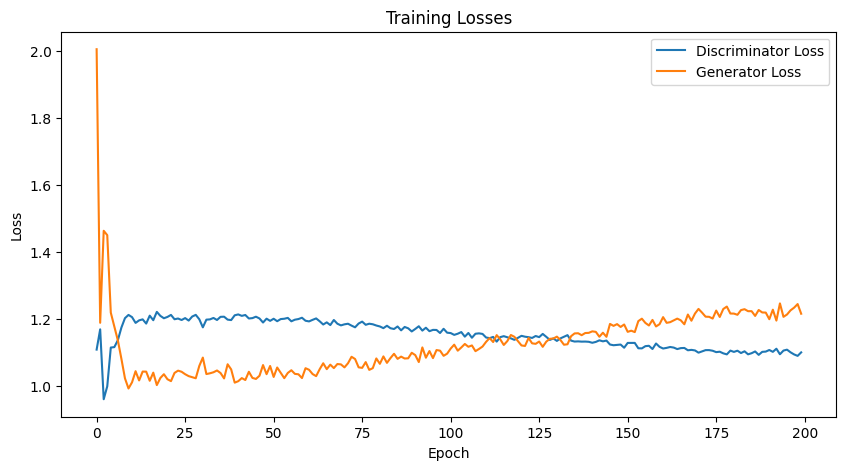

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Cell 9: Generate and Display a Final Sample

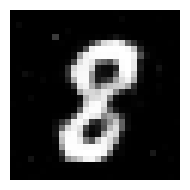

In [10]:
# Switch generator to evaluation mode and generate a new sample
generator.eval()
with torch.no_grad():
    z = torch.randn(1, 100, device=device)
    sample = generator(z).cpu()
    # Scale from [-1, 1] to [0, 1]
    sample = (sample + 1) / 2
    # Reshape to (1, 1, 28, 28) for display purposes
    display_images(sample.view(1, 1, 28, 28), n_cols=1, figsize=(2, 2))


In [11]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

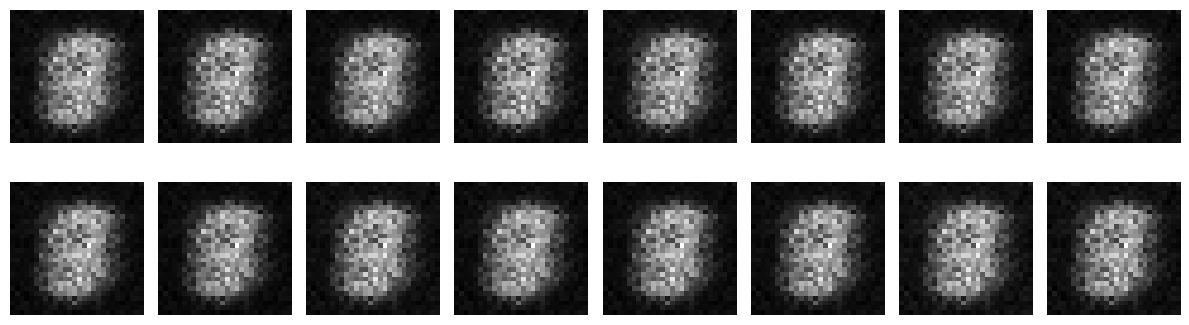

In [12]:
show_generated_images(epoch=1, n_cols=8)

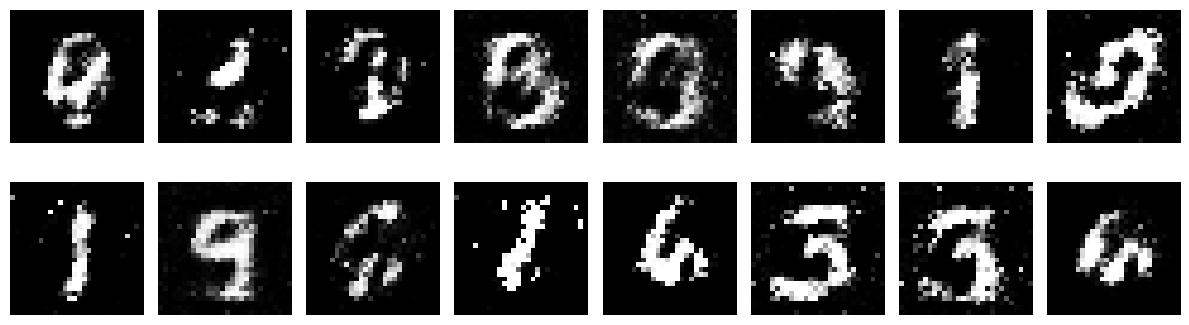

In [13]:
show_generated_images(epoch=10, n_cols=8)

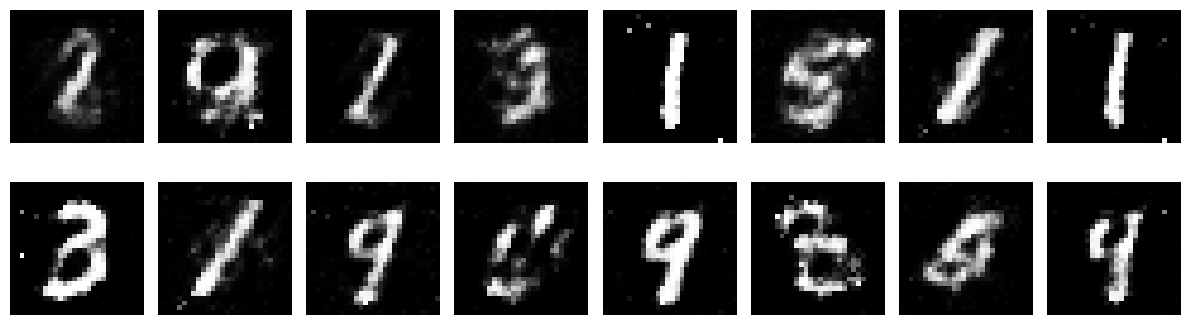

In [14]:
show_generated_images(epoch=50, n_cols=8)

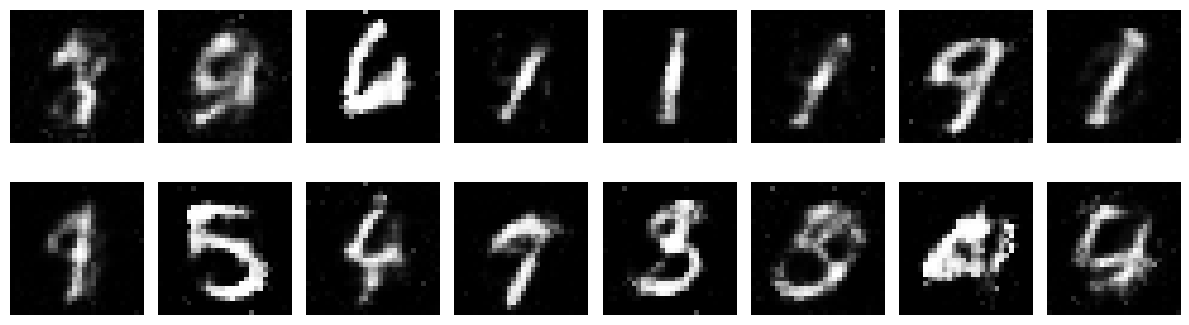

In [15]:

show_generated_images(epoch=100, n_cols=8)

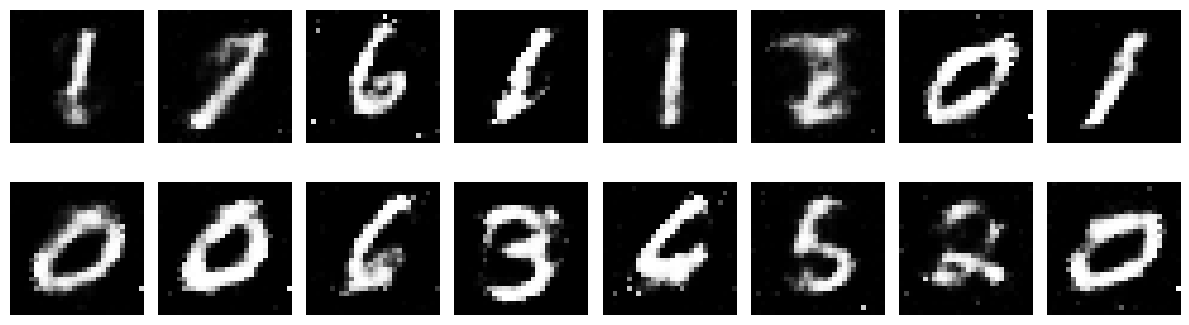

In [16]:
show_generated_images(epoch=120, n_cols=8)

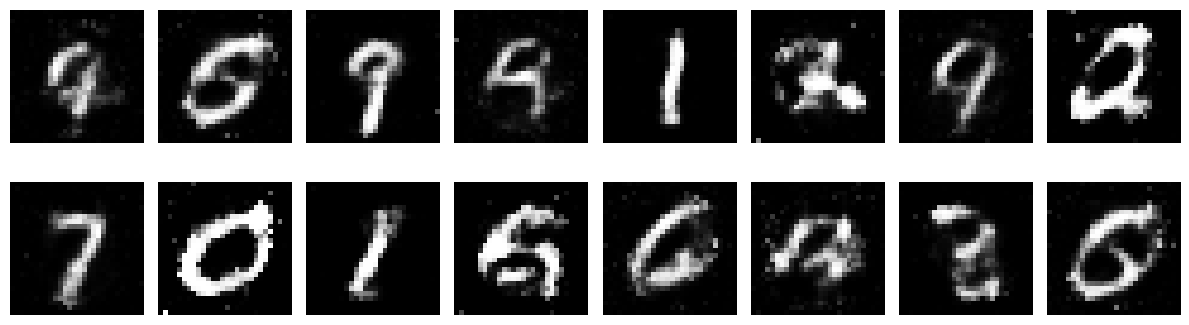

In [17]:
show_generated_images(epoch=140, n_cols=8)

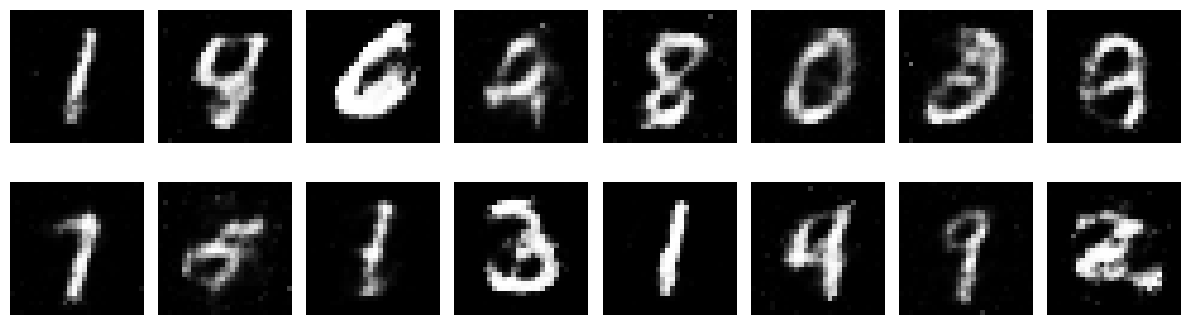

In [18]:
show_generated_images(epoch=160, n_cols=8)

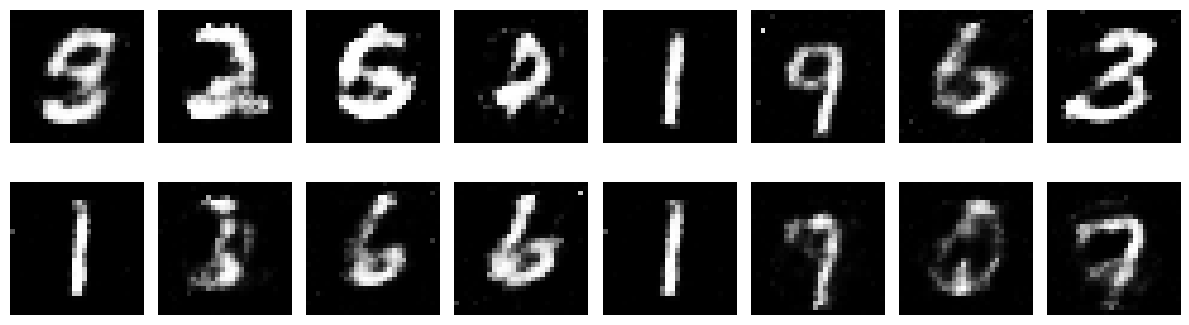

In [19]:
show_generated_images(epoch=180, n_cols=8)

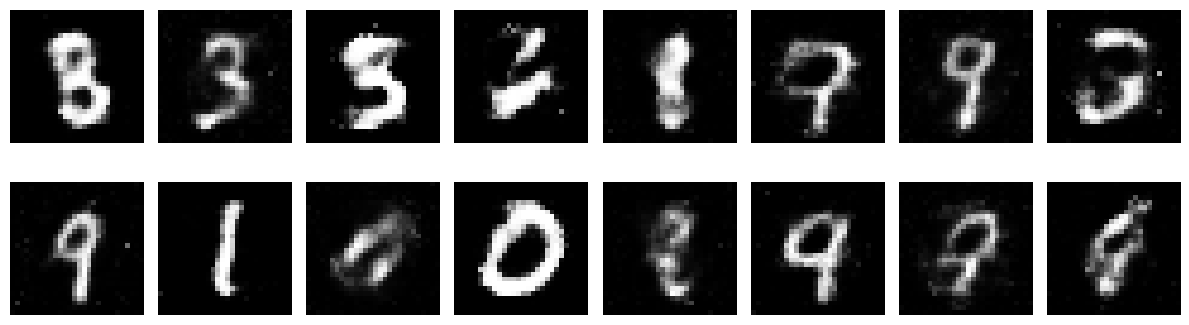

In [20]:
show_generated_images(epoch=200, n_cols=8)